# ASHRAE: Great Energy Predictor

In [1]:
%load_ext autoreload
%autoreload 2

## Dataset Description

The assessment of energy efficiency improvements in buildings can be difficult due to the lack of a baseline for comparison. Counterfactual models are used to estimate the energy consumption of a building before and after retrofitting. By comparing the actual energy consumption of a retrofitted building with the modeled values of the original building, the savings from the retrofit can be calculated. More accurate counterfactual models could help improve market incentives and financing options for energy efficiency projects.

The competition being described challenges participants to build counterfactual models for four energy types using historical usage rates and observed weather data. The dataset provided includes three years of hourly meter readings from over one thousand buildings at various locations around the world. This competition aims to improve the accuracy of counterfactual modeling for energy efficiency assessments, which could have significant implications for promoting energy efficiency measures in buildings and supporting sustainable practices in the built environment.

### Files
#### train.csv
- `building_id` - Foreign key for the building metadata.
- `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
- `timestamp` - When the measurement was taken
- `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

#### building_meta.csv
- `site_id` - Foreign key for the weather files.
- `building_id` - Foreign key for training.csv
- `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- `square_feet` - Gross floor area of the building
- `year_built` - Year building was opened
- `floor_count` - Number of floors of the building

#### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- `site_id`
- `air_temperature` - Degrees Celsius
- `cloud_coverage` - Portion of the sky covered in clouds, in oktas
- `dew_temperature` - Degrees Celsius
- `precip_depth_1_hr` - Millimeters
- `sea_level_pressure` - Millibar/hectopascals
- `wind_direction` - Compass direction (0-360)
- `wind_speed` - Meters per second

#### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

- `row_id` - Row id for your submission file
- `building_id` - Building id code
- `meter` - The meter id code
- `timestamp` - Timestamps for the test data period

## Data Loading and Merging

In [2]:
import numpy as np
import pandas as pd
from utils import styled_print, process_timestamp, plot_box_plot_hist_plot, plot_box_plot_dis_plot

### Training Dataset

In [3]:
# Train Dataset
train = pd.read_csv('../data/raw_data/train.csv')
weather_train = pd.read_csv('../data/raw_data/weather_train.csv')
building = pd.read_csv('../data/raw_data/building_metadata.csv')

In [4]:
styled_print("Training Dataset Summary", header=True)
styled_print(f"The shape of train.csv is {train.shape}")
styled_print(f"The columns in train.csv are {list(train.columns)}")
styled_print(f"The shape of weather_train.csv is {weather_train.shape}")
styled_print(f"The columns in weather_train.csv are {list(weather_train.columns)}")
styled_print(f"The shape of building_metadata.csv is {building.shape}")
styled_print(f"The columns in building_metadata.csv are {list(building.columns)}")

› Training Dataset Summary
    The shape of train.csv is (20216100, 4)
    The columns in train.csv are ['building_id', 'meter', 'timestamp', 'meter_reading']
    The shape of weather_train.csv is (139773, 9)
    The columns in weather_train.csv are ['site_id', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    The shape of building_metadata.csv is (1449, 6)
    The columns in building_metadata.csv are ['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']


Let's check few samples from each csv files.

In [5]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [7]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


As we can see that `building_id` can act as primary key to merge and extend the `train.csv` by adding building information from `building_metadata.csv`.

After that we can use `site_id`as primary key to merge and extend the `train.csv` by adding weather information from `weather_train.csv`.

In [8]:
train_df = train.merge(building, on='building_id', how='left')
train_df = train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [9]:
styled_print("Training Dataset Summary", header=True)
styled_print(f"The shape of train_df is {train_df.shape}")
styled_print(f"The columns in train_df are {list(train_df.columns)}")

› Training Dataset Summary
    The shape of train_df is (20216100, 16)
    The columns in train_df are ['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [10]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


### Test Dataset

In [11]:
# Test Dataset
test = pd.read_csv('../data/raw_data/test.csv')
weather_test = pd.read_csv('../data/raw_data/weather_test.csv')

In [12]:
styled_print("Test Dataset Summary", header=True)
styled_print(f"The shape of test.csv is {test.shape}")
styled_print(f"The columns in test.csv are {list(test.columns)}")
styled_print(f"The shape of weather_test.csv is {weather_test.shape}")
styled_print(f"The columns in weather_test.csv are {list(weather_test.columns)}")

› Test Dataset Summary
    The shape of test.csv is (41697600, 4)
    The columns in test.csv are ['row_id', 'building_id', 'meter', 'timestamp']
    The shape of weather_test.csv is (277243, 9)
    The columns in weather_test.csv are ['site_id', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


Let's check few samples from each csv files.

In [13]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [14]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


Same as training data, we can see that `building_id` can act as primary key to merge and extend the `train.csv` by adding building information from `building_metadata.csv`.

After that we can use `site_id`as primary key to merge and extend the `train.csv` by adding weather information from `weather_train.csv`.

In [15]:
test_df = test.merge(building, on='building_id', how='left')
test_df = test_df.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [16]:
styled_print("Test Dataset Summary", header=True)
styled_print(f"The shape of test_df is {test_df.shape}")
styled_print(f"The columns in test_df are {list(test_df.columns)}")

› Test Dataset Summary
    The shape of test_df is (41697600, 16)
    The columns in test_df are ['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [17]:
test_df.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


From this point onwards we will not use `test_df` for any data analysis purpose. We will purely decide all the preprocessing steps and transformations based on the `train_df` and then apply them to `test_df`. This will allow us to make sure that there is no direct or indirect data leak from training to test.

**As we can see that we are dealing with a true big data problem. We have roughly `20 million` samples for the training while we have `40 million` samples for the testing. This is a huge dataset and very realistic one as our test set is double the size of training set.** 

## Data Exploration

### Statistics

In [18]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,20216100.0,799.278000,426.913309,0.0,393.0,895.000,1179.000,1448.0
meter,20216100.0,0.662441,0.930992,0.0,0.0,0.000,1.000,3.0
meter_reading,20216100.0,2117.121076,153235.624998,0.0,18.3,78.775,267.984,21904700.0
site_id,20216100.0,7.992232,5.099060,0.0,3.0,9.000,13.000,15.0
square_feet,20216100.0,107782.981330,117142.443648,283.0,32527.0,72709.000,139113.000,875000.0
year_built,8088455.0,1968.276736,30.208153,1900.0,1951.0,1969.000,1993.000,2017.0
floor_count,3506933.0,4.184848,4.008277,1.0,1.0,3.000,6.000,26.0
air_temperature,20119442.0,15.987953,10.947293,-28.9,8.6,16.700,24.100,47.2
cloud_coverage,11390735.0,1.900423,2.402909,0.0,0.0,0.000,4.000,9.0
dew_temperature,20115960.0,7.747429,10.178667,-35.0,0.0,8.900,16.100,26.1


**Observations**
- We have builds with `square_feet` in the range from 283 - 875000 sqft. This is a huge range and there are very high chances that we will see some outliers as well as skewed distribution in this feature. If we see that the distribution is very skewed we can use log transformation to reduce the skewness.
- We have buildings built in 1900 as well as 2017. As the dataset is collected in the year 2017, this indicates that we have very recently built buildings and century old buildings in the dataset. This is a great dynamics in the dataset and it proves that the dataset is close to the real world scenario.
- `air_temperature` ranges in between -28.9 to 47.2 degree celsius. Also `dew_temperature` ranges between -35 to 26 degree celsius. These two range indicates that we have dataset not just from cold climate zones but from very hot climate zones too. Again this highlights that the dataset is not biased to specific type of weather. 
- `meter_reading` our target variable has very high standard deviation of 153235.62 which is a huge amount. Also the range of this feature is from 0 to 21904700 while 75% of data falls under 267.98. This shows that there will be heavy skewness in our target variable. Same like `square_feet` we can use log transform to treat skewness in the data. Also it seems like we will have some outliers in this and we will need to treat them based on data analysis. 

In [19]:
styled_print("Other Specific Statistics", header=True)
styled_print(f"Total unique buildings in training dataset are {train_df['building_id'].nunique()}")
styled_print(f"Total unique sites in training dataset are {train_df['site_id'].nunique()}")
styled_print(f"Total unique buildings in test dataset are {test_df['building_id'].nunique()}")
styled_print(f"Total unique sites in test dataset are {test_df['site_id'].nunique()}")

› Other Specific Statistics
    Total unique buildings in training dataset are 1449
    Total unique sites in training dataset are 16
    Total unique buildings in test dataset are 1449
    Total unique sites in test dataset are 16


### Initial Feature Engineering

As we have `timestamp` information available, before we start any other data  analysis, we can split the time stamp into hour, week and month information. This will allow us to better understand the change in different features as well as our target variable with respect to time. 

In [20]:
train_df = process_timestamp(train_df, column="timestamp", drop=True)
test_df = process_timestamp(test_df, column="timestamp", drop=True)

In [21]:
styled_print("Training Dataset Summary", header=True)
styled_print(f"The shape of train_df is {train_df.shape}")
styled_print(f"The columns in train_df are {list(train_df.columns)}")

› Training Dataset Summary
    The shape of train_df is (20216100, 21)
    The columns in train_df are ['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear']


In [22]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,year,dayofweek,dayofyear
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,...,NaN,1019.7,0.0,0.0,0,1,1,2016,4,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,...,NaN,1019.7,0.0,0.0,0,1,1,2016,4,1
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,...,NaN,1019.7,0.0,0.0,0,1,1,2016,4,1
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,...,NaN,1019.7,0.0,0.0,0,1,1,2016,4,1
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,...,NaN,1019.7,0.0,0.0,0,1,1,2016,4,1


## Exploratory Data Analysis

### Analysis of Target Variable - `meter_reading`

We will start our data analysis by creating distribution and box plots for our target variable.

In [23]:
target = 'meter_reading'

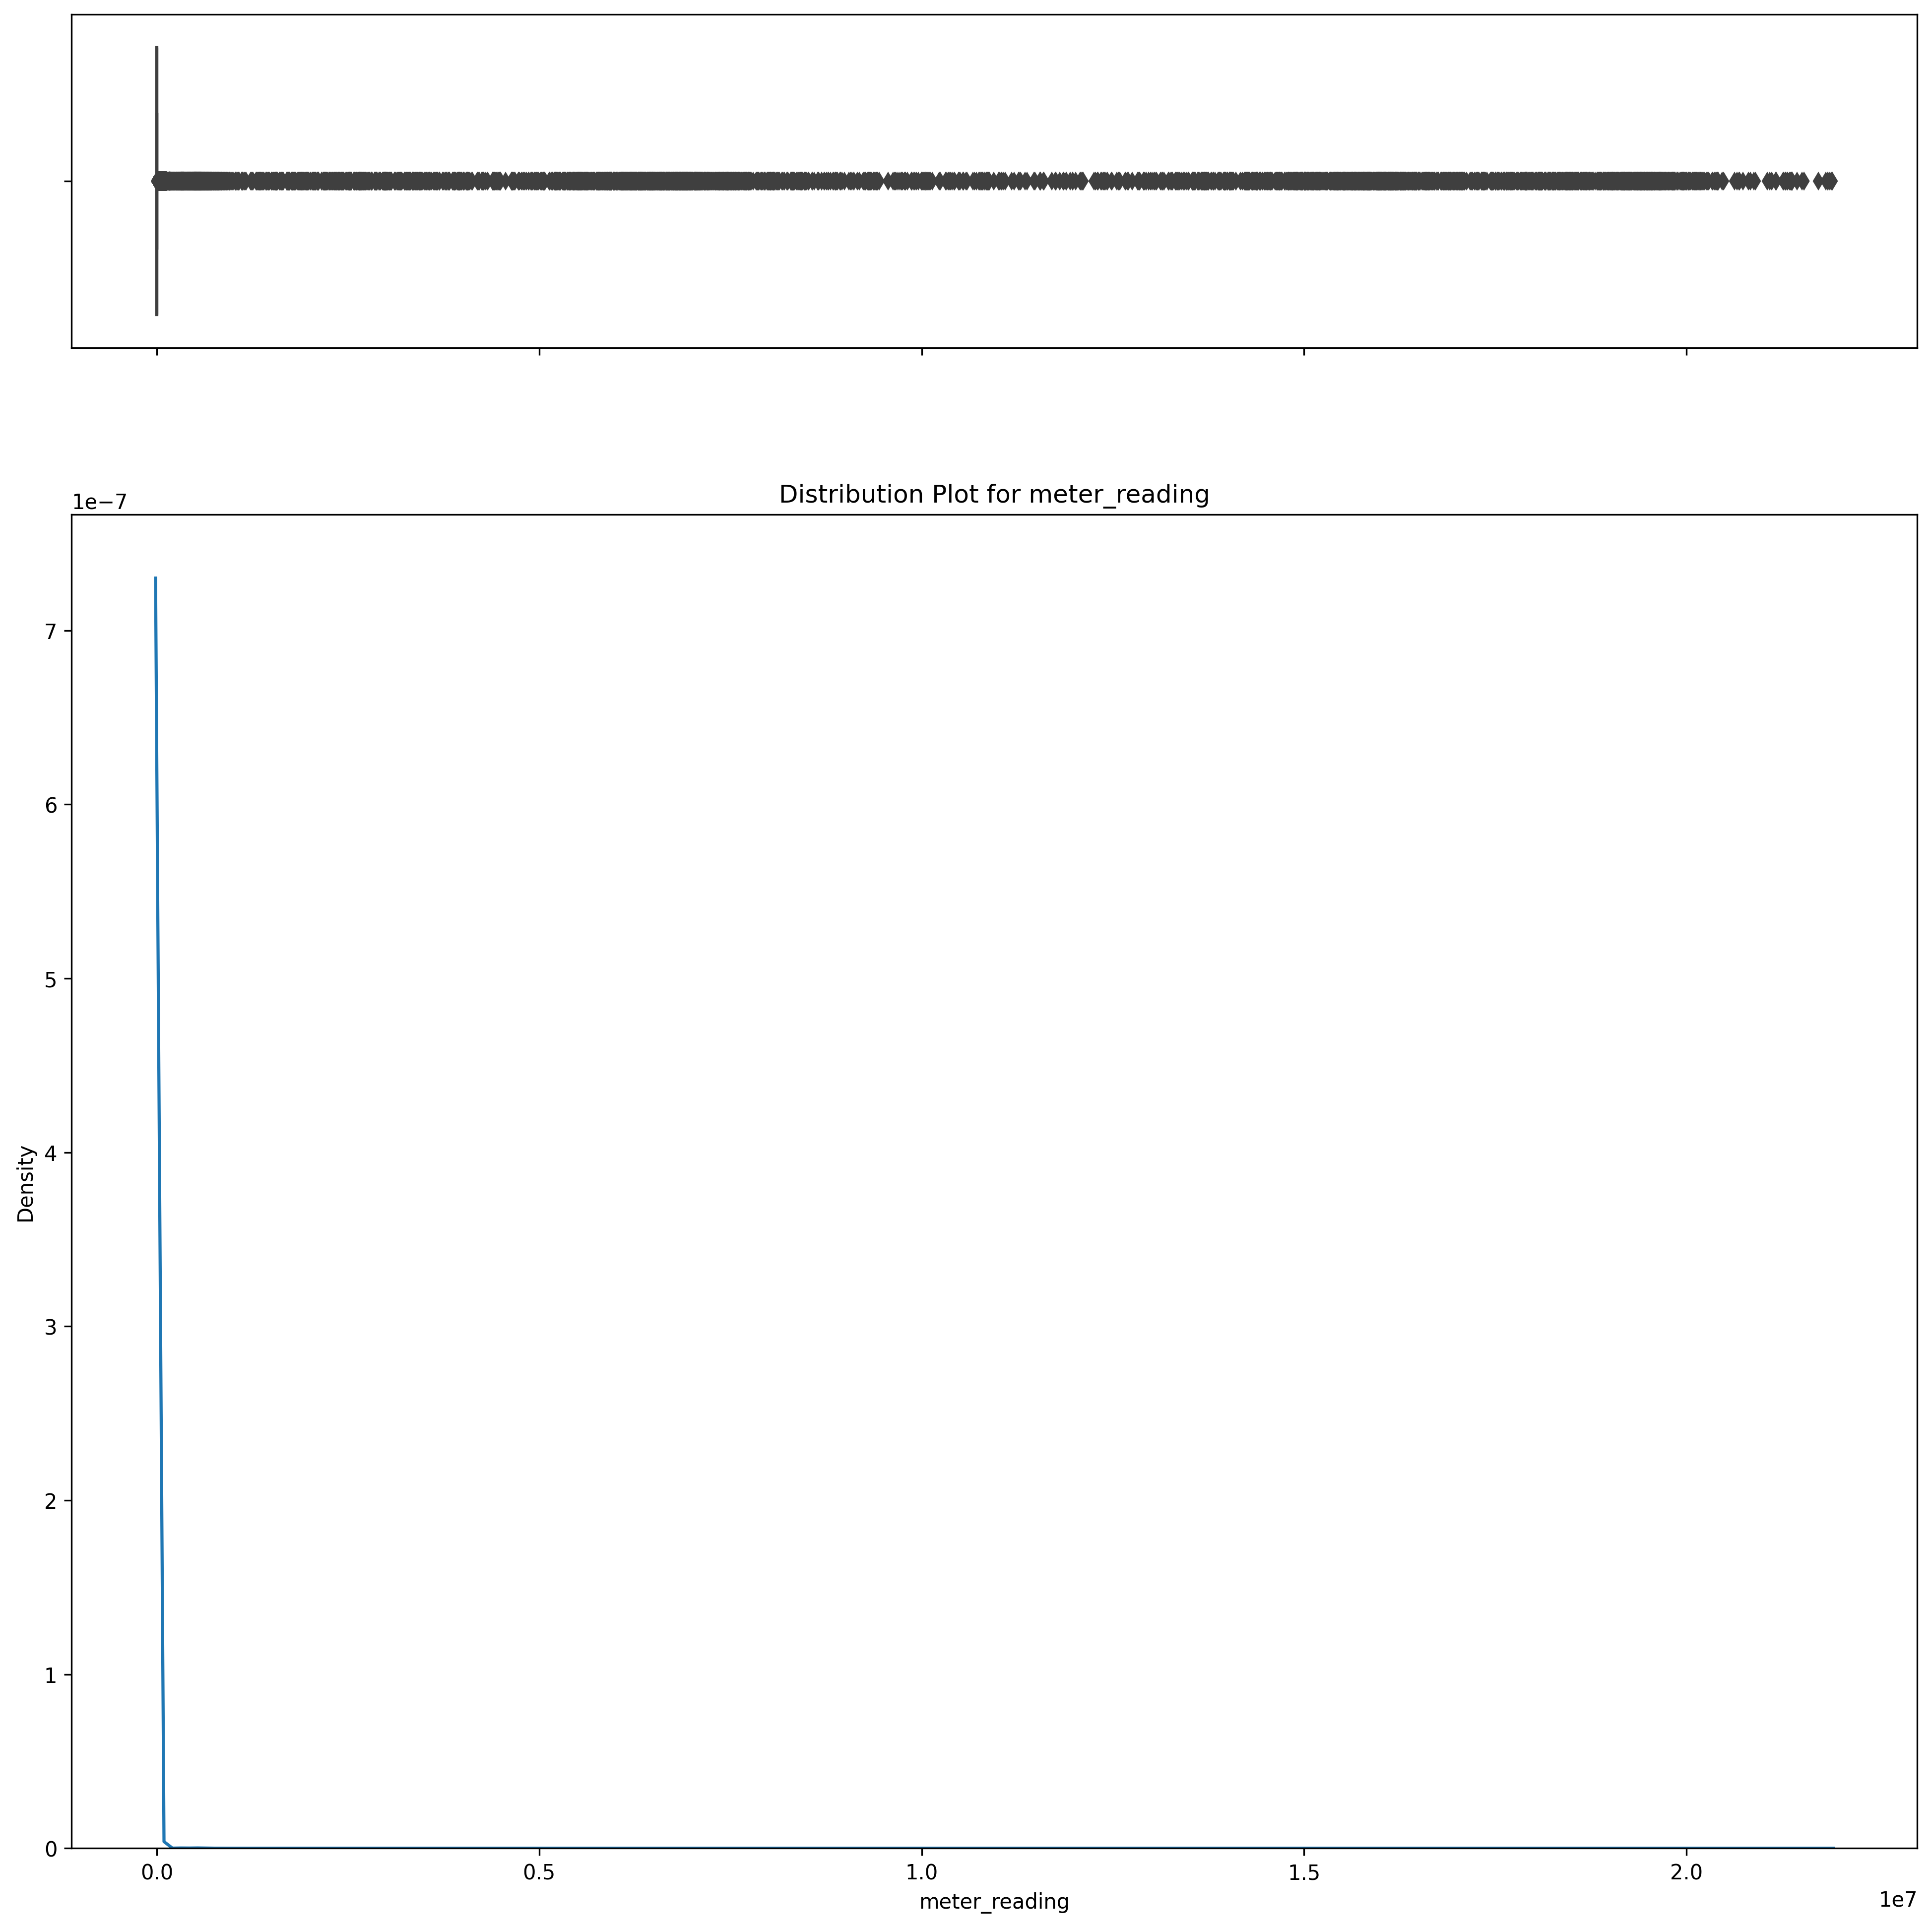

In [24]:
plot_box_plot_dis_plot(
    train_df, 
    column=target,
    title=f"Distribution Plot for {target}")

As we can see that the target variable is extreamly skewed to right and highlights that there is huge proportion of values which are 0. This target variable is almost useless as it is for any further analysis. That is why we prefer that we rectify the issues with the target variable first before jumping on any further analysis. To reduce the amount of skewness can be reduced by using `log` transformation. 

In [25]:
train_df[f'log_{target}'] = np.log1p(train_df[target])

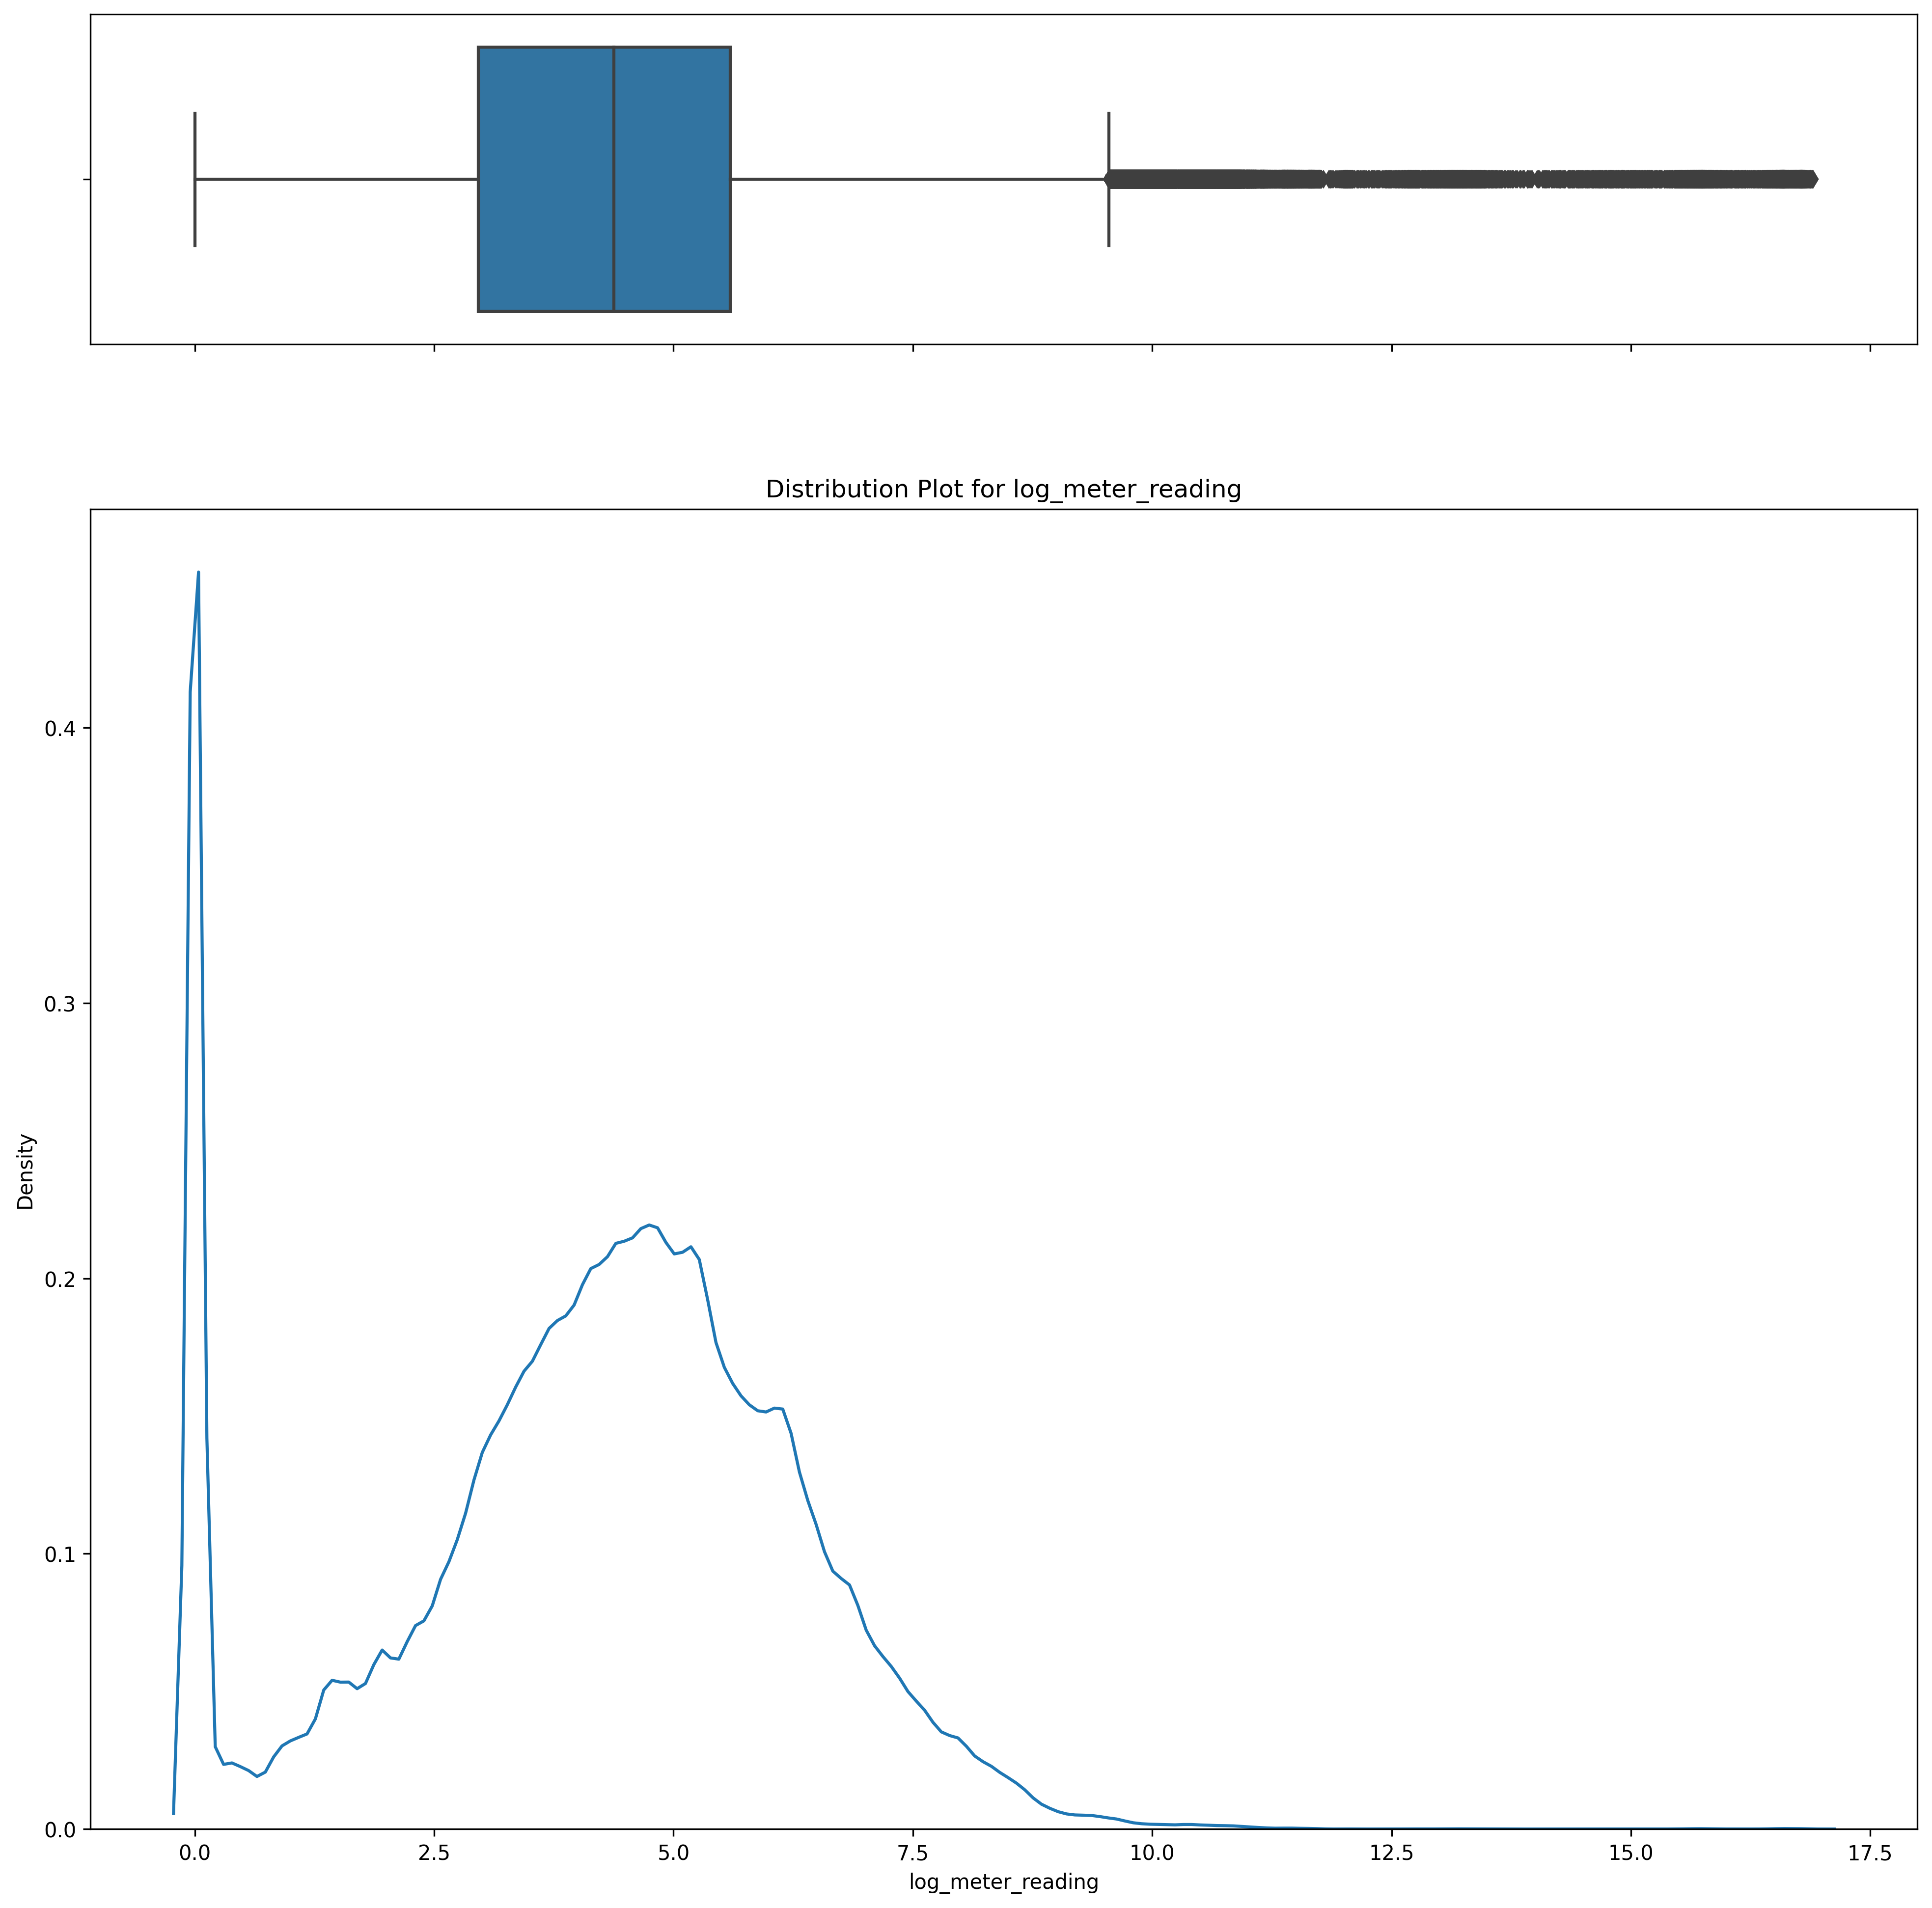

In [26]:
plot_box_plot_dis_plot(
    train_df, 
    column=f'log_{target}',
    title=f"Distribution Plot for log_{target}")

This target variable distribution looks much better than what we have without applying log transformation. Still we can see that there is a high proportion of datasamples where `log_meter_reading` is `0.0`. These samples are the main cause why we see lots of outliers towards right side. Also `meter_reading` of `0.0` indicates either there is some fault in the meter or there is no reading available at given time. In either of these cases, it is not useful to keep these samples in the dataset for model creation. As a data processing and cleaning step we will remove all the samples with `log_meter_reading = 0.0`.

In [27]:
drop_meter_readings_indices = list(train_df[train_df[f'log_{target}']==0.0].index)
train_df.drop(drop_meter_readings_indices, axis=0, inplace=True)

In [30]:
print(len(drop_meter_readings_indices))

1873976


In [28]:
styled_print("Training Dataset Summary", header=True)
styled_print(f"The shape of train_df is {train_df.shape}")
styled_print(f"The columns in train_df are {list(train_df.columns)}")

› Training Dataset Summary
    The shape of train_df is (18342124, 22)
    The columns in train_df are ['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'log_meter_reading']


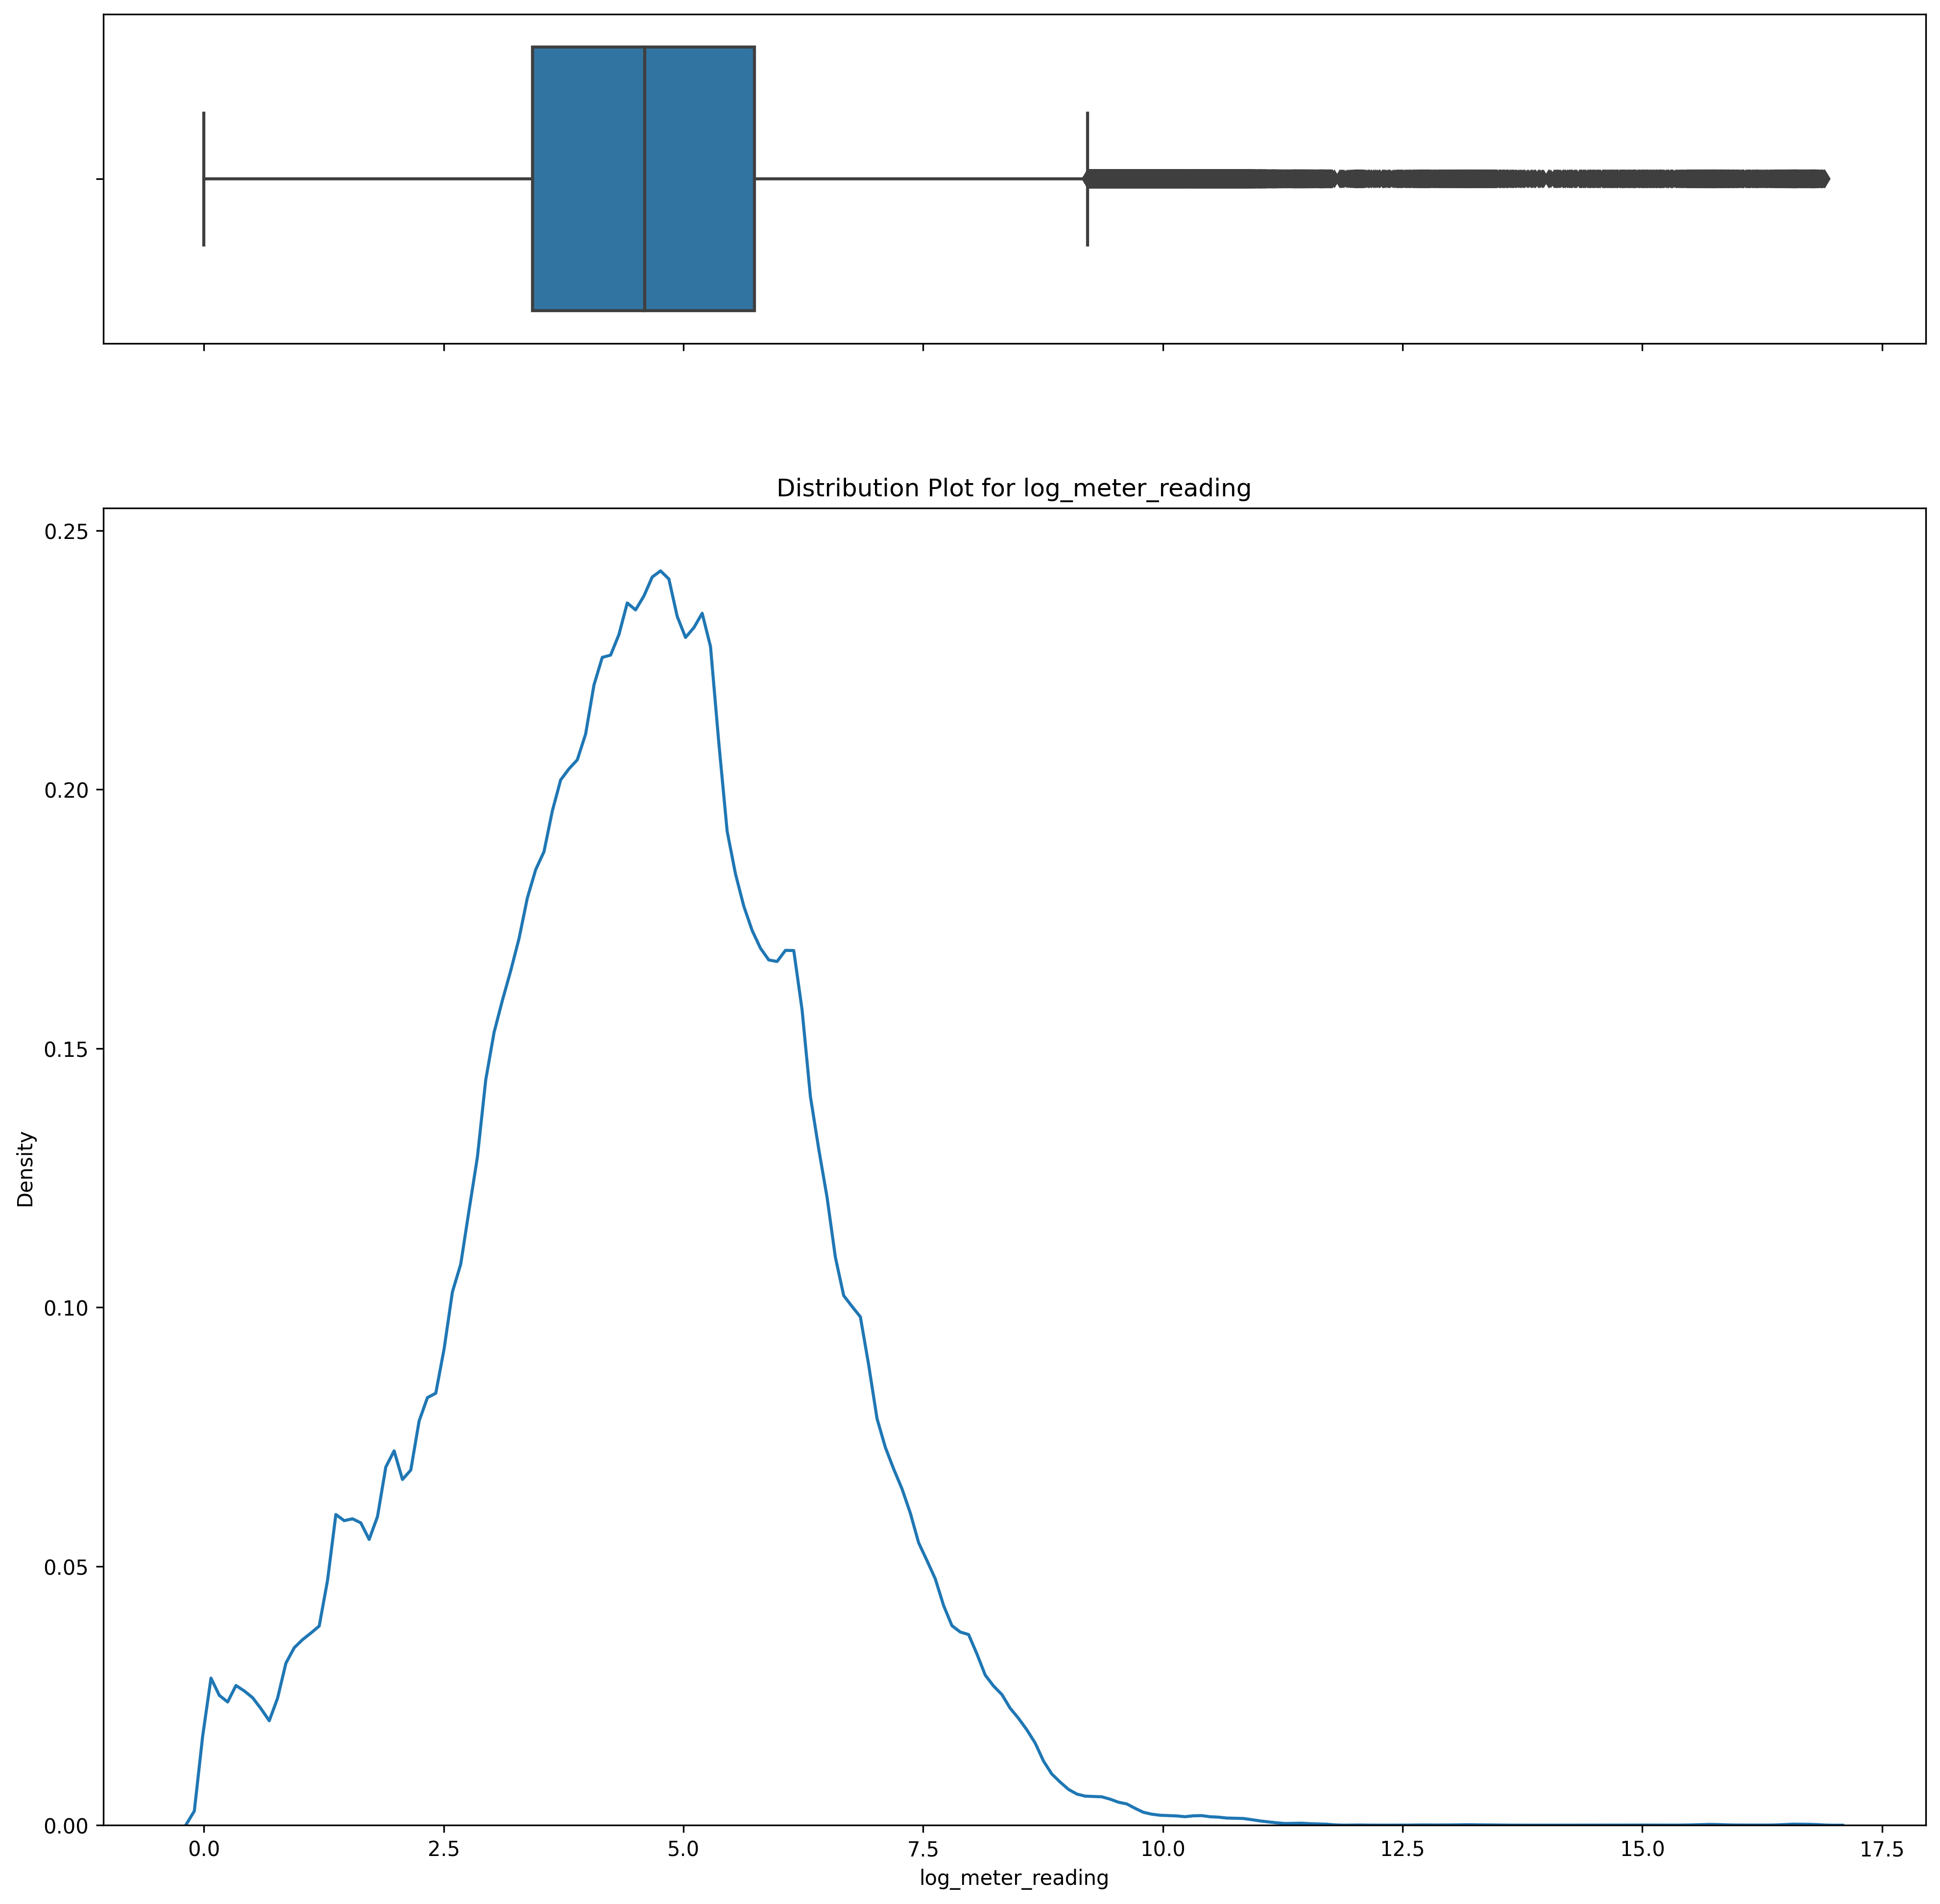

In [29]:
plot_box_plot_dis_plot(
    train_df, 
    column=f'log_{target}',
    title=f"Distribution Plot for log_{target}")

As we can see that this is a much better distribution of target variable. In this process we have removed `1,873,976` samples which is roughly `9%` of the data. This is not a big problem as we still have `18,342,124` samples for the training. 

### Univariate Analysis - Categorical Features